In [2]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, date

import random

## CFM 101: Python Portfolio Roboadvisor
### Contributors: Landon Trinh, Ethan Zemelman, Jessie Deng

## Goal
The focus of this project is to dynamically generate the safest possible portfolio given a CSV of unknown stock tickers. With a given list of stocks, the roboadvisor will generate a portfolio valued at $750,000, composed of a 10-22 stocks. For the CFM101 portfolio competition, the performance will be tracked from November 25, 2023 to December 4, 2023.

Our goal is to explain WHY we selected our stocks through statistics and graphs, throughly explaning our approach and strategy.

## Process

1. Filtering Stock Data

Before performing statistical analysis on the stock candidates, we filter the stock data to remove stock tickers that don't satisfy our requirements or exist.

2. Creating Stock Portfolio Candidates

We use financial metrics, including but not limited to standard deviation, expected returns, and beta values to select portfolios that possess low risk. To ensure a stable expected return, some example of these desired traits include low beta value and low standard deviation. 

3. Optimizing Portfolio Weights

Since stocks with a high weighting can have a more prominent effect on the overall performance of a portfolio, it is crucial for stocks in the portfolio to be weighted. We will aim to achieve optimal performance by conducting a Monte Carlo simulation to find stock weights that optimizes for least portfolio risk.

4. Selecting the Final Portfolio

To choose the best possible combination of stocks within a portfolio, we use different portfolio metrics to optimize for risk and return.

## Introduction
> "Theory will only take you so far." - J. Robert Oppenheimer

Yet, throughout the many years of educations, students are taught about theory --- whether it be game theory, psychoanalytic theory. These theories are often abstract and based on various assumptions. For example, in finance, we are taught to assume that people behave rationally and with the goal to increase financial position. That is, people will not make impulse purchases; they will buy and sell stocks with the goal of earning money. 

However, in real life, there are much more complications to a situation than we assume. Therefore, more people are resorting to examining hard, cold data that does not lie. Proposed in 1952 by Harry Markowitz, the Modern Portfolio Theory is an example of such. It is a mathematical framework used to build portfolios that maximizes returns while keeping the risk below a certain level. Under this method, 

This project utilizes the Modern Portfolio Theory as an underlying framework to build a robo advisor. The robo advisor will then perform analysis and make selections to come up with a final portfolio that meets the criteria of a "safe" portfolio. A "safe" portfolio is one that deviates as little as possible from the starting value. Moreover, it is our focus to keep the difference between the initial and final value as little as possible over a short period of time. 

Diversification is a risk management strategy that focuses on mixing a wide variety of investments within a portfolio in attempt to reduce portfolio risk. Hence, we plan to create 3 sets of 22 stocks in order to maximize diversification and reduce portfolio risk, but may adjust the number of stocks based on the list of stock given as well as the statistics of these stocks. For example, the robo advisor may choose to have less than 22 stocks in a portfolio in case the vast majority of stocks have an extremely high beta values. 

## 1. Setup
Before implementing our trading strategy, we will initialize required and useful constants as part of the rules:
- Currency of valid stocks (USD or CAD)
- Required average monthly volume (150,000 shares)
- The number of stocks we wish to purchase on the start date (10-22 stocks)
- Time interval (Janurary 1, 2023 - October 31, 2023)
- Minimum number of trading days for month (18 days)
- Minimum stock weighting: $\frac{100}{2n}$%, $n$ = number of stocks in portfolio
- Maximum stock weighting: 20%
- Initial investment amount: 750,000 CAD
- Buying date of roboadvisor: November 25, 2023 - December 4, 2023
- Trading fee for each stock trade: $4.95 CAD

In the end, our roboadvisor should create two DataFrames:

1. ${\verb|Portfolio_Final|\\}$
- Index: Starts at 1 and ends at number of stocks in portfolio
- Headings: Ticker, Price (price of stock on Nov 25), Currency (CAD or USD), Shares, Value, Weight (adds up to 100%)

2. ${\verb|Stocks_Final|\\}$

We should output this DataFrame to a CSV file titled "Stocks_Group_15.csv"
- Index: Same as "Portfolio Final"
- Headings: Tickers and Shares from "Portfolio_Final"

In [3]:
# Investment amount (CAD)
capital = 750000

# Minimum and maximum number of stocks for portfolio
min_stocks = 12
max_stocks = 22

# Number of stocks to buy for portfolio
num_stocks = max_stocks

# Maximum and minimum weightings of each stock in portfolio
min_weight = 1 / (2 * num_stocks)
max_weight = 0.20

# Filtering requirements
min_trading_days = 18
min_avg_volume = 150000

trading_fee = 4.95

## 2. Filtering
After reading in the CSV file containg stock tickers, we must filter the list of stocks to make sure they are valid stock tickers according to the following rules:

- Include stocks that have an average monthly volume of at leaest 150,000 shares based on Jan 1, 2023 - Oct 31, 2023 (drop any months that don't have at least 18 trading days)
- Stock denominated in USD or CAD

To accomplish this, we first read the csv file containing all the tickers and extract these tickers to be put into a pandas data frame. 

We then set the parameters for the filtering, which includes the start and end dates as well as filter interval. 

We use a function called get_short_months to recursively check for months that have less than 18 trading days and drop these months. We then recursively use the function called filter_volume to to determine if the stock meets the trading volume requirement. The short months with less than 18 trading days that we obtain from the get_short_months function are dropped before we perform the calculation to determine the average monthly volume. 

We then retrieve the filtered tickers, which are ones that satisifies the above mentioned requirements and therefore, can be used for our portfolio. 

In [4]:
# Read in CSV ticker file
tickers = pd.read_csv("tickers_example.csv", header=None)
tickers = tickers.rename(columns={0: "ticker"})
tickers_lst = tickers["ticker"].tolist()
tickers.head()

,ticker
0,AAPL
1,ABBV
2,ABT
3,ACN
4,AGN


For the start and end dates, we chose a time interval of almost 1.5 years. This is because we believe that the more recent data from a stock is a better predictor of the outcomes of the stock in the *near* future. However, if we were using this for practical purposes and to create a long-term portfolio, it would be a good idea to use a longer time interval to consider the performance of the companies in different economic environments.

In [5]:
# Set parameters for filtering tickers
filter_start_date = "2023-01-01"
filter_end_date = "2023-10-31"

# Set parameters for retrieving stock data
start_date = "2022-05-01"
end_date = "2023-11-25"

In [6]:
# Determines months with less than 18 trading days
def get_short_months(market_index):
    short_months = []
    for month in range(1, 11):
        trading_days = len(market_index.history(start=str(date(2023, month, 1)), end=str(date(2023, month+1, 1))))
        if trading_days < min_trading_days:
            short_months.append(month)
    return short_months

# Keeps stocks with valid average monthly volume
def filter_volume(tickers, short_months):

    # Retrieve monthly volume data for tickers
    volume_data = yf.download(tickers=tickers, interval="1mo", start=filter_start_date, end=filter_end_date).Volume

    # Drop short months from volume DataFrame
    for short_month in short_months:
        volume_data.drop(str(date(2023, short_month, 1)))

    # Determine whether stocks meets average monthly volume requirement
    for ticker in tickers:
        if (volume_data[ticker]).mean() < min_avg_volume:
            print(f"{ticker} does not meet the required minimum average monthly volume")
            tickers.remove(ticker)

    # Return finalized list of tickers
    return tickers


# Retrieve filtered tickers
def filter_tickers(tickers):
    
    # Initialize list to separately store CAD and USD tickers
    cad_tickers = []
    usd_tickers = []
    
    for ticker in tickers:
        try:
            stock_ticker = yf.Ticker(ticker)
            base_currency = stock_ticker.fast_info["currency"]
            
            # Store ticker in appropriate list
            if base_currency == "CAD":
                cad_tickers.append(ticker)
            
            elif base_currency == "USD":
                usd_tickers.append(ticker)
    
        except:
            print(f"{ticker} may be delisted")

    # Determine months that have less than 18 trading days for CAD and USD stocks
    cad_short_months = get_short_months(yf.Ticker("^GSPTSE"))
    usd_short_months = get_short_months(yf.Ticker("^GSPC"))

    # Filter months that have an average monty volume of less than 150k
    filtered_cad_tickers = filter_volume(cad_tickers, cad_short_months)
    filtered_usd_tickers = filter_volume(usd_tickers, usd_short_months)

    # Return valid tickers
    return filtered_cad_tickers, filtered_usd_tickers

cad_tickers, usd_tickers = filter_tickers(tickers_lst)
filtered_tickers = cad_tickers + usd_tickers

# Ensures number of stocks we will buy is maximum value in case filtered length is shorter than max
if len(filtered_tickers) < max_stocks:
    num_stocks = len(filtered_tickers)
    

AGN: No data found, symbol may be delisted


AGN may be delisted


CELG: No data found, symbol may be delisted


CELG may be delisted


MON: No data found, symbol may be delisted


MON may be delisted


RTN: No data found, symbol may be delisted


RTN may be delisted


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  32 of 32 completed


In [7]:
# Get exchange rate data for CAD-USD
def get_exchange_data(exchange_ticker):
    exchange_data = yf.download(exchange_ticker, start=start_date, end=end_date, interval="1d").Close
    exchange_hist = pd.DataFrame(exchange_data)
    exchange_hist.rename(columns = {"Close": "CAD-USD"}, inplace=True)
    return exchange_hist

exchange_ticker = "CADUSD=X"
exchange_hist = get_exchange_data(exchange_ticker)

[*********************100%%**********************]  1 of 1 completed


In [8]:
# Create DataFrame with all closing prices of stocks

# Get CAD stock data
cad_stock_data = yf.download(tickers=cad_tickers, interval="1d", start=start_date, end=end_date).Close

# Get USD stock data
usd_stock_data = yf.download(tickers=usd_tickers, interval="1d", start=start_date, end=end_date).Close

# Align USD stock data and exchange data
aligned_usd_data = pd.merge(usd_stock_data, exchange_hist, left_index=True, right_index=True, how='outer').dropna()

# Convert all USD stock data to CAD
usd_converted_data = pd.DataFrame()
for usd_ticker in usd_tickers:
    close_data = aligned_usd_data[usd_ticker]
    usd_converted_data[usd_ticker] = close_data / aligned_usd_data["CAD-USD"]

# Combine into final DataFrame
stock_data = pd.concat([cad_stock_data, usd_converted_data], axis=1).dropna()
display(stock_data)


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  32 of 32 completed


,RY.TO,SHOP.TO,T.TO,TD.TO,AAPL,ABBV,ABT,ACN,AIG,AMZN,...,PFE,PG,PM,PYPL,QCOM,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-02,129.699997,58.326000,31.879999,92.669998,203.025993,190.057302,145.020399,391.502382,75.909819,160.019847,...,62.131401,203.565817,126.692019,117.643506,186.715534,223.642196,644.128077,299.307800,229.528873,62.786902
2022-05-03,130.970001,59.714001,32.000000,93.669998,205.314555,192.595056,144.742389,392.425294,76.638924,159.963965,...,63.455950,201.104771,127.439729,116.780058,185.720325,222.127997,643.210809,298.805561,229.311692,63.687682
2022-05-04,132.600006,61.830002,32.060001,94.239998,213.066752,194.547569,148.487062,404.085007,82.059315,161.614114,...,63.732650,201.952677,129.056689,118.994995,191.287792,226.170051,651.469347,304.276558,235.885247,64.849190
2022-05-05,130.320007,52.963001,31.629999,93.349998,199.681094,193.834704,143.943103,380.460187,79.123487,148.269924,...,61.711736,196.738804,127.079043,108.813902,180.409704,216.889044,630.134773,294.840706,229.002115,62.717976
2022-05-06,129.589996,48.606998,32.279999,92.970001,201.743042,196.035031,144.008716,379.345662,79.822416,147.218676,...,62.903605,200.101188,126.910333,104.770930,180.321957,214.788098,640.862528,294.495070,230.783367,63.224280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,120.489998,93.870003,24.219999,84.779999,260.863597,190.191553,136.902164,450.835091,88.673548,199.652984,...,41.146285,207.752992,126.450559,77.754377,178.048446,212.634970,737.511365,301.459803,203.503577,51.762905
2023-11-20,120.529999,95.449997,24.200001,85.099998,262.650248,189.747484,138.836275,453.961697,88.295484,200.475752,...,41.129561,206.155417,126.736117,78.184583,177.674760,213.385315,734.103650,303.327096,205.195091,51.624598
2023-11-21,119.779999,95.540001,24.100000,84.220001,261.636250,190.394440,139.862313,453.252155,89.165482,197.489797,...,41.584023,205.326268,127.359656,76.031519,174.323519,210.568863,740.538774,304.675030,205.545858,50.792893


In [9]:
# Get daily returns of stocks
daily_returns = stock_data.pct_change().dropna()
daily_returns.index = daily_returns.index.tz_localize(None, ambiguous="infer").tz_localize("UTC")
daily_returns.head()

,RY.TO,SHOP.TO,T.TO,TD.TO,AAPL,ABBV,ABT,ACN,AIG,AMZN,...,PFE,PG,PM,PYPL,QCOM,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-03 00:00:00+00:00,0.009792,0.023797,0.003764,0.010791,0.011272,0.013353,-0.001917,0.002357,0.009605,-0.000349,...,0.021319,-0.012090,0.005902,-0.007340,-0.005330,-0.006771,-0.001424,-0.001678,-0.000946,0.014347
2022-05-04 00:00:00+00:00,0.012446,0.035436,0.001875,0.006085,0.037758,0.010138,0.025871,0.029712,0.070726,0.010316,...,0.004361,0.004216,0.012688,0.018967,0.029978,0.018197,0.012840,0.018310,0.028666,0.018238
2022-05-05 00:00:00+00:00,-0.017195,-0.143409,-0.013412,-0.009444,-0.062824,-0.003664,-0.030602,-0.058465,-0.035777,-0.082568,...,-0.031709,-0.025817,-0.015324,-0.085559,-0.056868,-0.041036,-0.032748,-0.031011,-0.029180,-0.032864
2022-05-06 00:00:00+00:00,-0.005602,-0.082246,0.020550,-0.004071,0.010326,0.011352,0.000456,-0.002929,0.008833,-0.007090,...,0.019313,0.017091,-0.001328,-0.037155,-0.000486,-0.009687,0.017025,-0.001172,0.007778,0.008073
2022-05-09 00:00:00+00:00,-0.014353,-0.089864,-0.014560,-0.005163,-0.026315,-0.005213,-0.036666,-0.020984,-0.035291,-0.045394,...,-0.001105,0.004592,0.016577,-0.019399,-0.033438,-0.007986,-0.019498,-0.011928,0.015562,0.010175


## 3. Stock Analysis

As widely known in finance, diversification plays an important role in reducing the risk of investment portfolios as it minimizes the effect that changes in a single stock can have on the entire portfolio. Since our trading strategy is to go safe, we could take advantage of this information by generating portfolios to contain as many stocks as possible. 

Since we want to diversify our portfolio as much as possible to reduce overall risk, we will choose the maximum number of stocks allowed (22 stocks). We will also place a large focus on LOW-RISK assets to reduce volatility within our portfolio.

In this part, we will utilize statastical analysis taught in the CFM 101 class to complete the selection of our portfolio candidates and final portfolio. For this section, our aim is to generate multiple portfolios each containing 22 stocks unless the statistics support it to be done in another way. For instance, in case the list of stocks contains a few stable stocks and some highly volatile ones, it may be more advantageous to take only the ones that are stable. In that case, a portfolio may be composed using less than 22 stocks. 

#### 3.1 - Standard Deviation
- Take 22 stocks with the LOWEST standard deviations'

#### 3.2 - Expected Returns
- Take 22 stocks with LOWEST expected returns

#### 3.3 - Beta Value
- Take 22 stocks with the LOWEST beta values (stock with beta less than 1 is considered less volatile than the market)

#### 3.4 - Correlation
- Get 11 pairs of stocks that have LOWEST correlation

#### 3.5 - Hybrid
- Take 22 stocks based on a mixture of the above-mentioned metrics
    - 10 stocks with the lowest standard deviation
    - 6 stocks with the lowest expected returns
    - 3 pairs of stocks with the least correlation

## 3.1 - Standard Deviation

Standard deviation is a statistic that measures the dispersion of a dataset relative to its mean with its formula given below, where $x_{i}$ is a single data point, $\overline{X}$ is the mean of the data points and $N$ is the number of data points in a given dataset: 

$$\sigma_X=\sqrt{\frac{\sum(x_i-\overline{X})^2}{N}}
$$

In finance, standard deviation is often used as a measure of the risk of investing in an asset. For example, a volatile stock will have a high standard deviation while a stable blue-chip stock will have a lower standard deviation. 

To create a safe portfolio, we want to select stocks that are less volatile, indicated by a low standard deviation. Hence, we will take a look at stocks that have the lowest standard deviations.

The get_std_returns function below calculates the standard deviation of the daily historical returns of each stocks, and sorts it from lowest to highest. 

We use this measure to create one of our portfolios by extracting 22 stocks with the lowest standard deviation of expected return. Since low standard deviation indicates a smaller spread relative to the mean, which is the expected return in our case, we know that the stock is more predictable. Therefore, a portfolio composed of these stocks will be more likely to succeed since the future movements of the stocks are more likely to be able to be predicted by our statistics. 

In [10]:
# Calculate standard deviation of returns for each stock
def get_std_returns(stocks):

    std_returns = {} 

    # Add standard deviation of each stock to DataFrame
    for stock in stocks:
        stock_std = daily_returns[stock].std()
        std_returns[stock] = stock_std

    stock_std_returns = pd.DataFrame(std_returns.items(), columns=["ticker", "std"])
    return stock_std_returns

# Get standard deviation of stock returns
stock_std_returns = get_std_returns(filtered_tickers)

# Sort from lowest to highest standard deviation
sorted_stock_std_returns = stock_std_returns.sort_values(by="std").reset_index(drop=True)
display(sorted_stock_std_returns.head(num_stocks))

,ticker,std
0,RY.TO,0.010147
1,T.TO,0.011284
2,TD.TO,0.011418
3,KO,0.011556
4,PEP,0.011990
5,CL,0.012308
6,PG,0.012469
7,BMY,0.013167
8,MRK,0.013345
9,PM,0.013437


In [11]:
# Get stocks with lowest standard deviations
l_std_stocks = list(sorted_stock_std_returns.nsmallest(num_stocks, columns="std")["ticker"])
print(l_std_stocks)

['RY.TO', 'T.TO', 'TD.TO', 'KO', 'PEP', 'CL', 'PG', 'BMY', 'MRK', 'PM', 'ABBV', 'LMT', 'MO', 'ABT', 'UNH', 'PFE', 'UNP', 'UPS', 'BK', 'ACN', 'TXN', 'BAC']


## 3.2 - Expected Returns

Expected return is the profit or loss that an investor can anticipate and it can be calculated using the following formula: 

\begin{align*}
E(X)=\overline{X}=\frac{\sum x_i}{N}
\end{align*}

where $x_i$ are individual returns of some security $X$, 
$N$ is the total number of observations (time periods for us)

Expected return is important to know when investing as it allows investors to have a sense of what the outcome of the invesment may be based on historical data. Since we are choosing to go safe as our strategy, we could use this to our advantage by creating a portfolio that has an overall value to be closest to 0. In this case, we are assuming equal weights for each stock in our calculations. 

In our code, we first use the get_expected_returns to obtain the expected return of all stocks on the ticker list and store these into a data frame. We then sort these stocks from lowest to highest expected return. The sorted list of stocks is then put into the get_minimum_returns function which recursively calculates the total expected return of the top 22 stocks on the sorted list and moves up by one each time. We then take the set of 22 stocks that gives the lowest total expected return to compose the second portfolio candidate. 

In [12]:
# Calculate expected returns for each stock
def get_expected_returns(stocks):

    expected_returns = {} 

    # Calculate average reteurn for stock and add to DataFrame
    for stock in stocks:
        stock_expected_return = daily_returns[stock].mean()
        expected_returns[stock] = stock_expected_return

    stock_expected_returns = pd.DataFrame(expected_returns.items(), columns=["ticker", "expected_return"])
    return stock_expected_returns

# Get expected returns of stocks
stock_expected_returns = get_expected_returns(filtered_tickers)

# Sort from lowest to highest expected returns
sorted_stock_expected_returns = stock_expected_returns.sort_values(by="expected_return").reset_index(drop=True)
sorted_stock_expected_returns

,ticker,expected_return
0,PFE,-0.000910
1,BMY,-0.000816
2,PYPL,-0.000725
3,T.TO,-0.000667
4,MO,-0.000476
5,USB,-0.000276
6,TD.TO,-0.000210
7,RY.TO,-0.000173
8,BAC,-0.000170
9,UPS,-0.000112


In [13]:
# Function that helps graph given input
def graph_relationship(x, y, x_title, y_title):
    plt.scatter(x, y)
    plt.title(f"{x_title} vs. {y_title}")
    plt.xlabel(f"{x_title} (%)")
    plt.ylabel(f"{y_title} (%)")
    plt.show()

In [14]:
def get_minimal_returns(returns_df):

    # Calculate number of possible combinations
    combinations = (returns_df.shape[0] - num_stocks) + 1

    # Store sets of stocks, and their absolute expected returns and standard deviations
    stock_sets = []
    stock_sets_er = []

    for _ in range(combinations):

        # Get set of 22 stocks
        stock_set_df = returns_df.head(num_stocks)

        # Get stock set and its average expected return and standard deviation
        stock_set = list(stock_set_df["ticker"])
        stock_set_er = stock_set_df["expected_return"].mean()

        # Store information in separate lists
        stock_sets.append(stock_set)
        stock_sets_er.append(abs(stock_set_er))

        # Drop first row
        returns_df = returns_df.drop(returns_df.index[0])
    
    # Get index that produces least absolute return
    min_er_index = stock_sets_er.index(min(stock_sets_er))

    # Return list of stocks that produce lowest expected return
    stock_minimal_returns = stock_sets[min_er_index]
    return stock_minimal_returns

# Print stocks with lowest expected returns on average
l_er_stocks = get_minimal_returns(sorted_stock_expected_returns)
print("Set of Stocks with Lowest Expected Returns:")
print(l_er_stocks)

Set of Stocks with Lowest Expected Returns:
['PYPL', 'T.TO', 'MO', 'USB', 'TD.TO', 'RY.TO', 'BAC', 'UPS', 'TXN', 'KO', 'ABT', 'ABBV', 'PG', 'QCOM', 'PM', 'C', 'UNP', 'AXP', 'PEP', 'CL', 'LMT', 'UNH']


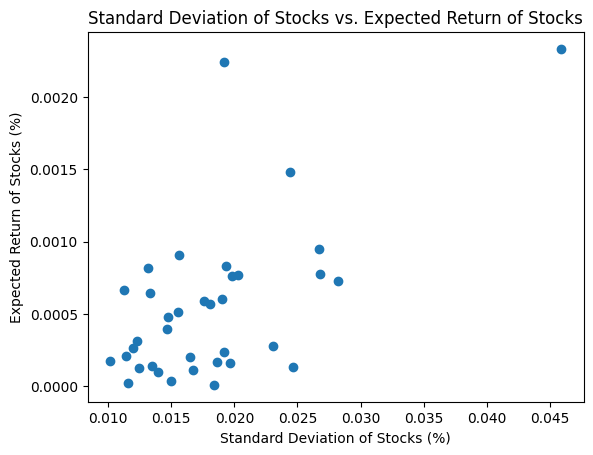

In [15]:
# Graph the correlation between the standard deviation and expected returns for stocks
stock_stds = stock_std_returns["std"]
stock_ers = abs(stock_expected_returns["expected_return"])
graph_relationship(stock_stds, stock_ers, "Standard Deviation of Stocks", "Expected Return of Stocks")


As a measure to examine the relationship between standard deviation and expected return, we made a scatter plot of the stocks with the x-axis as the standard deviation and the y-axis as the magnitude (absolute value) of the expected return. Although the relationship does not appear to be very strong, we can tell that there is somewhat of a positive relationship between standard deviation and the magnitude of the expected return. That is, we get that a low standard deviation often indicates a low expected return. Low standard deviation means that there are little movements in the daily return of the stock prices, which means stock prices does not change much from day to day. This means that the return will also be low. 

## 3.3 Beta Value
The beta value of a stock measures its volatility relative to the broader market. A beta value greater than 1 indicates that the stock is more volatile than the market and a beta value less than 1 indicates a more stable stock. Since we are choosing to go safe with our portfolio, stocks need to be chosen so that the beta values are as low as possible.

The formula of beta value of a stock relative to the market is as follows, where  ${Cov(r_i,r_m)}$  is the covariance between the stock and the market index,  ${Var(r_m)}$  is the variance of the market index: 

\begin{align*}
\beta=\frac{Cov(r_i,r_m)}{Var(r_m)}
\end{align*}

where ${r_i}$ and ${r_m}$ represent the expected return of the stock index that of market index respectively. In our calculation, we use the S&P 500 as the stock market index. 

The S&P 500 is a stock market index tracking the stock performance of the largest companies listed on the US stock exchange. Because of the sizes of these companies as well as the diversity of the companies on the S&P 500, this index is a reasonably accurate representation of the market. 

Since we are choosing to go safe with our portfolio, stocks need to be chosen so as to obtain as low of a beta value as possible. Moreover, as a volatile stock may lead to capital gains/losses, we look for the lowest magnitude beta values by taking the absolute value. The aim of this part is to use beta value as a statistical measure to quantify our various portfolios which will allow us to choose the appropriate set of stocks. 

This measure is used to create our second portfolio candidate, which is either composed of the 22 stocks with the lowest beta values if all of these values are less than one, or a minimum of 10 stocks with beta values less than one. We make this choice because a beta value greater than one indicates greater volatility than the market. Although it is important to hold a diversified portfolio, we do not want to take on more volatile stocks that could make the portfolio more risky. 

In [16]:
# Set S&P 500 as market index
market_index = yf.download(tickers="^GSPC", start=start_date, end=filter_end_date)["Close"]
market_returns = market_index.pct_change().dropna()
market_returns.index = market_returns.index.tz_localize(None, ambiguous="infer").tz_localize("UTC")
market_variance = market_returns.var()

# Get betas of every stock compared to S&P 500
def get_stock_betas(stocks): 
        betas = {}

        for stock in stocks:
                stock_returns = daily_returns[stock]
                covariance = stock_returns.cov(market_returns)
                stock_beta = covariance / market_variance
                betas[stock] = stock_beta
        
        stock_betas = pd.DataFrame(betas.items(), columns=["ticker", "beta"])
        return stock_betas

# Returns stock betas
stock_betas = get_stock_betas(filtered_tickers)

# Sorts stock betas
sorted_stock_betas = stock_betas.sort_values(by="beta").reset_index(drop=True)
display(sorted_stock_betas)

[*********************100%%**********************]  1 of 1 completed


,ticker,beta
0,MRK,0.265670
1,BMY,0.294638
2,ABBV,0.314595
3,CL,0.377999
4,LMT,0.409472
5,T.TO,0.411665
6,MO,0.419171
7,PEP,0.462077
8,RY.TO,0.464765
9,PG,0.465879


In [17]:
# Exctracts stocks with beta less than 1
l_beta_stocks = list(stock_betas[stock_betas["beta"] < 1]["ticker"])

# Ensures list is diversified if list of lowest beta stocks are not enough
if len(l_beta_stocks) < num_stocks:
    for stock in l_std_stocks:
        if stock not in l_beta_stocks:
            l_beta_stocks.append(stock)

            if len(l_beta_stocks) == num_stocks:
                break

print("Lowest Beta Stocks:")
print(l_beta_stocks)

Lowest Beta Stocks:
['RY.TO', 'T.TO', 'TD.TO', 'ABBV', 'ABT', 'AIG', 'BAC', 'BIIB', 'BK', 'BMY', 'CAT', 'CL', 'KO', 'LLY', 'LMT', 'MO', 'MRK', 'PEP', 'PFE', 'PG', 'PM', 'UNH', 'UNP', 'UPS', 'USB']


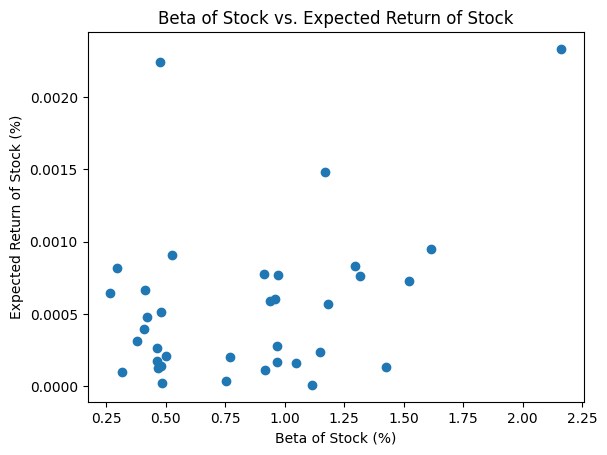

In [18]:
# Graph relationship between beta and expected returns for each stock
graph_relationship(stock_betas["beta"], stock_ers, "Beta of Stock", "Expected Return of Stock")

As shown above, we see that the data points on the graph with expected return vs beta value is pretty randomly dispersed. This indicates that there may not be a correlation between the expected return and volatility. Therefore, although we are including this portfolio with the lowest 22 expected returns, it is likely that this portfolio may be less accurate than the other ones. For this reason, we are also not including the expected return measure in the hybrid portfolio that we generate later on as we want the portfolio to be as stable as possible. 

## 3.4 - Correlation

In finance, correlation is a statistic that measures the degree to which two securities move in relation to each other. Correlation is closely tied to diversification. Correlations are computed as the correlation coefficent which takes on a value between -1 and 1. 

The formula of the correlation between $X$ and $Y$ is given as follows, 

where $\sigma_X$ and $\sigma_Y$ is the deviation of the stock, and the deviation of the market index respectively: 

$$ COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y} $$

A positive correlation indicates that when one security moves up or down, the other security moves in the same direction. A negative correlation indicates that two assets move in opposite directions, while a zero correlation implies no relationship at all. 

Hence, we hope to factor in negatively correlated stocks in our portfolio since their opposite movements in prices should theoretically offset each other to produce minimal volatility within the portfolio. 

In this part, we first calculate the correlation of expected return of all possible pairs of stocks on a given ticker list. We sort these pairs based on their correlation values. Since in step 1, we calculated the correlation of all stocks with each other, a stock may appear more than once. In the next step, we remove these duplicates and loops through the pairs to get the 11 least correlated pairs of unique stocks. These 22 stocks will then be used to make up the third portfolio. 

In [19]:
# Get stock correlation pairs
corr_pairs = daily_returns.corr()

# Sort pairs by lowest correlations
corr_pairs["Stock 1"] = corr_pairs.index
corr_pairs = corr_pairs.melt(id_vars="Stock 1", var_name="Stock 2")
corr_pairs.rename(columns={"value" : "Correlation"}, inplace=True)
corr_pairs.sort_values(by="Correlation", inplace=True)

# Remove duplicates within dataframe
corr_pairs = corr_pairs.iloc[:-(num_stocks)]
corr_pairs = corr_pairs.iloc[::2].reset_index(drop=True)
display(corr_pairs.head(num_stocks))

# Loop through pairs and get least correlated pairs of unique stocks
l_corr_pairs = []
for _, pair in corr_pairs.iterrows():
    stock1 = pair["Stock 1"]
    stock2 = pair["Stock 2"]

    if stock1 not in l_corr_pairs and stock2 not in l_corr_pairs:
        l_corr_pairs.append(stock1)
        l_corr_pairs.append(stock2)
    
    if len(l_corr_pairs) == num_stocks:
        break

print("Pairs of Least Correlated Stocks:")
print(l_corr_pairs)


,Stock 1,Stock 2,Correlation
0,MRK,SHOP.TO,-0.082999
1,UNH,SHOP.TO,-0.000802
2,SHOP.TO,ABBV,0.032959
3,SHOP.TO,BMY,0.033592
4,SHOP.TO,MO,0.037869
5,SHOP.TO,LLY,0.043783
6,LMT,SHOP.TO,0.048954
7,SHOP.TO,CL,0.051388
8,PYPL,MRK,0.059494
9,MRK,RY.TO,0.071383


Pairs of Least Correlated Stocks:
['MRK', 'SHOP.TO', 'AMZN', 'BMY', 'LLY', 'RY.TO', 'T.TO', 'UNH', 'TD.TO', 'ABBV', 'LMT', 'PYPL', 'BIIB', 'MO', 'PG', 'CAT', 'PFE', 'BA', 'USB', 'PEP', 'CL', 'AXP']


Text(0.5, 1.0, 'Tech Stocks Correlation Matrix')

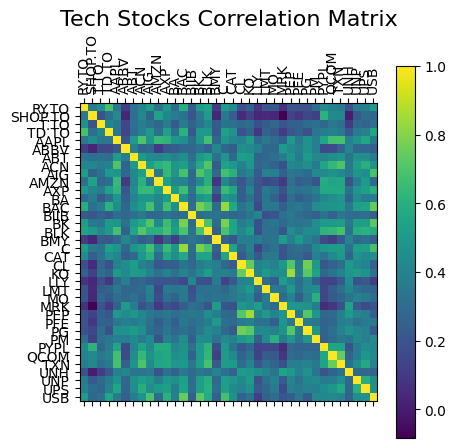

In [20]:
# Create correlation matrix
corr_matrix = daily_returns.corr()

# Create heat map for correlation matrix
plt.matshow(corr_matrix)
plt.xticks(range(daily_returns.shape[1]), daily_returns.columns, rotation=90, fontsize=10)
plt.yticks(range(daily_returns.shape[1]), daily_returns.columns, fontsize=10)

# Add a colorbar legend
cb = plt.colorbar()

plt.title("Tech Stocks Correlation Matrix", fontsize=16)

To visually examine the correlation, we've also created a correlation matrix that assigns the correlation between every two stocks a colour. The warmer the colour, meaning the closer to yellow it is, is the higher the correlation. For example, yellow would indicate a correlation of 1 whereas dark purple indicates a correlation of 0. As shown below, the diagonal of this graph is entirely yellow due to the fact that these are the correlations of the stock and itself, which gives a correlation of 1. Examining this graph, we know that the pairs chosen should be the one with darker colours. 


## 3.5 - Hybrid Portfolio

Although standard deviation, betas and correlations are both good measures to use when choosing stocks, there may be certain downsides and uncertainties as they do not take the other measures into account as much. So as a final measure, we want to create a mixed portfolio that encapsulates stocks with the lowest standard deviations, betas, and correlations, in an attempt to diverisfy and reduce risk.

In this portfolio, we will choose 22 stocks using the following criteria: 
- 6 stocks with least correlation with each other
- 10 stocks with lowest standard deviations
- 6 stocks with lowest betas

We chose to have 10 stocks with the lowest standard deviation to ensure that it will be reasonably easy for the expected return of the entire portfolio to be predicted. 

There are 6 stocks with lowest betas in an attempt to obtain a somewhat stable portfolio. It's also important to note that in real life, stocks that have low betas are also likely to have low standard deviations and vice versa. This is because if a stock has a low standard deviation, its expected return will not have changed much. Then that means the stock probably did not change very much compared to the general market either. So from this, we know that 16/22, which is a majority of our portfolio will be relatively stable and easy to predict. 

The final 6 stocks are then chosen to have least correlation with each other. The correlation coefficient assesses whether the movement of two stocks are correlated in our case. By choosing 3 pairs of stocks with a correlation coefficient that is as small as possible, we know that in case one stock plummets or skyrockets, the other ones will not change significantly. This measure is implemented to lower the risk of the prices of many stocks in the portfolio either increasing or decreasing as it could jeopardize our portfolio. 

As we are going safe, we want to first make sure that the returns of the portfolio is predictable and stable, and then optimize for a 0 return over time. However, as mentioned earlier in part 3.3, there is a low correlation between the expected return and beta value. This means that stocks with low returns are not necessarily less volatile. Therefore, we have excluded this measure in our hybrid portfolio. 


In [21]:
# Number of stocks to get for each category
n_corr_stocks = 6
n_std_stocks = 10
n_beta_stocks = 6

hybrid_stock_lst = []

def add_unique_stocks(stock_lst, n_stocks):
    unique_stocks = []

    for stock in stock_lst:
        if stock not in hybrid_stock_lst:
            unique_stocks.append(stock)

            if len(unique_stocks) == n_stocks:
                return unique_stocks

# Add lowest correlated pairs
hybrid_stock_lst += l_corr_pairs[:n_corr_stocks]

# Add loweset stds
hybrid_stock_lst += add_unique_stocks(l_std_stocks, n_std_stocks)

# Add loweset beta stocks
hybrid_stock_lst += add_unique_stocks(l_beta_stocks, n_beta_stocks)

print("Final Hybrid Stock List:")
print(hybrid_stock_lst)

Final Hybrid Stock List:
['MRK', 'SHOP.TO', 'AMZN', 'BMY', 'LLY', 'RY.TO', 'T.TO', 'TD.TO', 'KO', 'PEP', 'CL', 'PG', 'PM', 'ABBV', 'LMT', 'MO', 'ABT', 'AIG', 'BAC', 'BIIB', 'BK', 'CAT']


### Preparing DataFrames For Portfolio Weightings

Based on the calculations we've conducted above, we prepare the data frames so that the portfolios could be weighted in the next step. 

Five seperate data frames are created: 
- 1. 22 stocks with the lowest standard deviations
- 2. 22 stocks with the lowest beta values
- 3. 22 stocks with the lowest expected returns
- 4. 11 pairs of stocks with the least correlation to each other
- 5. 22 stocks chosen using a mixture of beta values, standard deviations, expected returns

These data frames are then stored in a list to be used later on. 

In [22]:
# Get DataFrames for each set of stock candidates

# 1. Lowest standard deviations
l_std_stocks_df = stock_data[l_std_stocks]
display(l_std_stocks_df.head())

# 2. Lowest betas
l_beta_stocks_df = stock_data[l_beta_stocks]
display(l_beta_stocks_df.head())

# 3. Lowest returns
l_er_stock_df = stock_data[l_er_stocks]
display(l_er_stock_df.head())

# 4. Least correlated stocks
l_corr_stocks_df = stock_data[l_corr_pairs]
display(l_corr_stocks_df.head())

# 5. Hybrid stock candidates
hybrid_stock_df = stock_data[hybrid_stock_lst]
display(hybrid_stock_df.head())

# Store portfolio DataFrames in a list
portfolio_candidates = {"Lowest Std": l_std_stocks_df, "Lowest Beta": l_beta_stocks_df, "Lowest Exp Returns": l_er_stock_df, "Lowest Corr": l_corr_stocks_df, "Hybrid": hybrid_stock_df}

,RY.TO,T.TO,TD.TO,KO,PEP,CL,PG,BMY,MRK,PM,...,MO,ABT,UNH,PFE,UNP,UPS,BK,ACN,TXN,BAC
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-02,129.699997,31.879999,92.669998,81.539429,215.621918,96.628853,203.565817,96.500325,112.656545,126.692019,...,71.179914,145.020399,644.128077,62.131401,299.307800,229.528873,54.882310,391.502382,223.642196,46.450740
2022-05-03,130.970001,32.000000,93.669998,81.209198,216.270342,95.898427,201.104771,96.619378,112.132543,127.439729,...,71.373457,144.742389,643.210809,63.455950,298.805561,229.311692,55.499817,392.425294,222.127997,47.801165
2022-05-04,132.600006,32.060001,94.239998,83.458200,223.128447,98.820260,201.952677,97.934724,113.604793,129.056689,...,72.382634,148.487062,651.469347,63.732650,304.276558,235.885247,57.495423,404.085007,226.170051,49.564134
2022-05-05,130.320007,31.629999,93.349998,82.167682,217.029154,96.917352,196.738804,97.121152,112.100102,127.079043,...,71.264636,143.943103,630.134773,61.711736,294.840706,229.002115,56.171051,380.460187,216.889044,47.815451
2022-05-06,129.589996,32.279999,92.970001,83.041990,218.584898,98.562657,200.101188,98.344601,113.377845,126.910333,...,72.562334,144.008716,640.862528,62.903605,294.495070,230.783367,56.130946,379.345662,214.788098,48.037113


,RY.TO,T.TO,TD.TO,ABBV,ABT,AIG,BAC,BIIB,BK,BMY,...,MO,MRK,PEP,PFE,PG,PM,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-02,129.699997,31.879999,92.669998,190.057302,145.020399,75.909819,46.450740,266.468401,54.882310,96.500325,...,71.179914,112.656545,215.621918,62.131401,203.565817,126.692019,644.128077,299.307800,229.528873,62.786902
2022-05-03,130.970001,32.000000,93.669998,192.595056,144.742389,76.638924,47.801165,264.818187,55.499817,96.619378,...,71.373457,112.132543,216.270342,63.455950,201.104771,127.439729,643.210809,298.805561,229.311692,63.687682
2022-05-04,132.600006,32.060001,94.239998,194.547569,148.487062,82.059315,49.564134,269.638145,57.495423,97.934724,...,72.382634,113.604793,223.128447,63.732650,201.952677,129.056689,651.469347,304.276558,235.885247,64.849190
2022-05-05,130.320007,31.629999,93.349998,193.834704,143.943103,79.123487,47.815451,256.246985,56.171051,97.121152,...,71.264636,112.100102,217.029154,61.711736,196.738804,127.079043,630.134773,294.840706,229.002115,62.717976
2022-05-06,129.589996,32.279999,92.970001,196.035031,144.008716,79.822416,48.037113,248.343533,56.130946,98.344601,...,72.562334,113.377845,218.584898,62.903605,200.101188,126.910333,640.862528,294.495070,230.783367,63.224280


,PYPL,T.TO,MO,USB,TD.TO,RY.TO,BAC,UPS,TXN,KO,...,PG,QCOM,PM,C,UNP,AXP,PEP,CL,LMT,UNH
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-02,117.643506,31.879999,71.179914,62.786902,92.669998,129.699997,46.450740,229.528873,223.642196,81.539429,...,203.565817,186.715534,126.692019,62.606961,299.307800,220.583176,215.621918,96.628853,553.720081,644.128077
2022-05-03,116.780058,32.000000,71.373457,63.687682,93.669998,130.970001,47.801165,229.311692,222.127997,81.209198,...,201.104771,185.720325,127.439729,64.498741,298.805561,221.574424,216.270342,95.898427,559.722908,643.210809
2022-05-04,118.994995,32.060001,72.382634,64.849190,94.239998,132.600006,49.564134,235.885247,226.170051,83.458200,...,201.952677,191.287792,129.056689,67.030937,304.276558,228.210640,223.128447,98.820260,572.053787,651.469347
2022-05-05,108.813902,31.629999,71.264636,62.717976,93.349998,130.320007,47.815451,229.002115,216.889044,82.167682,...,196.738804,180.409704,127.079043,65.354576,294.840706,217.818855,217.029154,96.917352,564.449021,630.134773
2022-05-06,104.770930,32.279999,72.562334,63.224280,92.970001,129.589996,48.037113,230.783367,214.788098,83.041990,...,200.101188,180.321957,126.910333,66.212969,294.495070,214.403284,218.584898,98.562657,576.483816,640.862528


,MRK,SHOP.TO,AMZN,BMY,LLY,RY.TO,T.TO,UNH,TD.TO,ABBV,...,BIIB,MO,PG,CAT,PFE,BA,USB,PEP,CL,AXP
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-02,112.656545,58.326000,160.019847,96.500325,372.171459,129.699997,31.879999,644.128077,92.669998,190.057302,...,266.468401,71.179914,203.565817,272.573576,62.131401,191.008431,62.786902,215.621918,96.628853,220.583176
2022-05-03,112.132543,59.714001,159.963965,96.619378,370.861343,130.970001,32.000000,643.210809,93.669998,192.595056,...,264.818187,71.373457,201.104771,275.014394,63.455950,197.718903,63.687682,216.270342,95.898427,221.574424
2022-05-04,113.604793,61.830002,161.614114,97.934724,378.468753,132.600006,32.060001,651.469347,94.239998,194.547569,...,269.638145,72.382634,201.952677,285.667549,63.732650,201.452159,64.849190,223.128447,98.820260,228.210640
2022-05-05,112.100102,52.963001,148.269924,97.121152,372.397518,130.320007,31.629999,630.134773,93.349998,193.834704,...,256.246985,71.264636,196.738804,275.034356,61.711736,191.656654,62.717976,217.029154,96.917352,217.818855
2022-05-06,113.377845,48.606998,147.218676,98.344601,380.833599,129.589996,32.279999,640.862528,92.970001,196.035031,...,248.343533,72.562334,200.101188,275.331530,62.903605,190.994010,63.224280,218.584898,98.562657,214.403284


,MRK,SHOP.TO,AMZN,BMY,LLY,RY.TO,T.TO,TD.TO,KO,PEP,...,PM,ABBV,LMT,MO,ABT,AIG,BAC,BIIB,BK,CAT
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-02,112.656545,58.326000,160.019847,96.500325,372.171459,129.699997,31.879999,92.669998,81.539429,215.621918,...,126.692019,190.057302,553.720081,71.179914,145.020399,75.909819,46.450740,266.468401,54.882310,272.573576
2022-05-03,112.132543,59.714001,159.963965,96.619378,370.861343,130.970001,32.000000,93.669998,81.209198,216.270342,...,127.439729,192.595056,559.722908,71.373457,144.742389,76.638924,47.801165,264.818187,55.499817,275.014394
2022-05-04,113.604793,61.830002,161.614114,97.934724,378.468753,132.600006,32.060001,94.239998,83.458200,223.128447,...,129.056689,194.547569,572.053787,72.382634,148.487062,82.059315,49.564134,269.638145,57.495423,285.667549
2022-05-05,112.100102,52.963001,148.269924,97.121152,372.397518,130.320007,31.629999,93.349998,82.167682,217.029154,...,127.079043,193.834704,564.449021,71.264636,143.943103,79.123487,47.815451,256.246985,56.171051,275.034356
2022-05-06,113.377845,48.606998,147.218676,98.344601,380.833599,129.589996,32.279999,92.970001,83.041990,218.584898,...,126.910333,196.035031,576.483816,72.562334,144.008716,79.822416,48.037113,248.343533,56.130946,275.331530


## 4. Portfolio Optimization

Since we are going safe, it is important that the stocks are weighted in such a way that allows the portfolio to generate as little return as possible with as little risk as possible. In this part, we will aim to optimize both of these metrics in our portfolio. 

First, we will determine the weights of each stock in the given portfolio. We do so by creating random weights for each stock, creating n number of random portfolios. This process will be done for each portfolio candidate. 

In order to decide which portfolio to choose, we need a way to choose one that considers both the expected returns and the risk. In order to do this, we will use a geometric approach in which we find the distance between each random portfolio and the origin, where the x-axis is the standard deviation for the portfolio, and the y-axis is the expected returns. The origin is the point where there is 0 standard deviation (low risk) and 0 expected return, which represents the ideal outcome of our portfolio. Thus, the portfolio that is closest to the origin will be the one that we choose. The formula we are using is as follows:
$$d=\sqrt{x^2+y^2}$$

We noticed that the expected return values were significantly lower than standard deviation values. Thus, when doing the optimization using our dist_from_origin function, these two values have a disproportionate effect on the calculation. So, we normalize the data points before putting it into the mathematical function for optimization to ensure that the best data point is chosen. 

In [23]:
def dist_from_origin(std_devs, expected_returns, num_portfolios):
    """
    Calculates the standardized distance of a portfolio from the origin (0,0) in the risk-return plane.
    """
    distances = {}

    # Normalize the standard deviations and expected returns
    min_std, max_std = min(std_devs.values()), max(std_devs.values())
    normalized_std_devs = {i: (std_dev - min_std) / (max_std - min_std) for i, std_dev in std_devs.items()}

    min_return, max_return = min(expected_returns.values()), max(expected_returns.values())
    normalized_returns = {i: (expected_return - min_return) / (max_return - min_return) for i, expected_return in expected_returns.items()}

    # Compute the distance of each portfolio from (0,0)
    for i in range(num_portfolios):
        distance = np.sqrt(normalized_std_devs[i]**2 + normalized_returns[i]**2)
        # Store the distance in the dictionary
        distances[i] = distance
    
    return distances

def best_overall_dist(port_std_devs, port_exp_returns, num_portfolios):
    # Flatten the dictionaries and keep a mapping from the new keys to the portfolio names and indices
    flat_std_devs = {}
    flat_exp_returns = {}
    key_mapping = {}
    new_key = 0
    for portfolio_name, std_devs in port_std_devs.items():
        for i, std_dev in std_devs.items():
            flat_std_devs[new_key] = std_dev
            flat_exp_returns[new_key] = port_exp_returns[portfolio_name][i]
            key_mapping[new_key] = (portfolio_name, i)
            new_key += 1

    # Compute the distances
    distances = dist_from_origin(flat_std_devs, flat_exp_returns, new_key)

    # Find the minimum distance and corresponding portfolio and index
    min_dist = float('inf')
    best_portfolio = None
    best_index = None
    for key, distance in distances.items():
        if distance < min_dist:
            min_dist = distance
            best_portfolio, best_index = key_mapping[key]
    
    return best_index, best_portfolio, min_dist

To achieve an optimal weighting, we have a function random_portfolios that creates n number of random portfolios based on the closing prices inputted. It creates these random portfolios using the random_weights function to assign random weighting to each stock. Then, random_portfolios will be called for each portfolio candidate (in optimize_weights) in order to find the optimal random portfolio (based on the distance from the origin as explained above) out of all the portfolio candidates.

Ideally, we would want the standard deviation as well as the expected return to both be 0 since that means that the portfolio is expected to have no return on investment with a very high certainty. In real life, it is nearly impossible to achieve this and with a given set of portfolios, there will often be a tradeoff between the expected return and the standard deviation. However, we will try to get as close as possible to this "optimal" portfolio by optimizing for the standard deviation and expected returns to both be as close to 0 as possible. We want the standard deviation to be low as it's important for the portfolio movements to be relatively predictable. We also want the expected returns to be low as this means that the portfolio will be more likely to generate as little return as possible (which is our goal). We do so by calculating the distance of the data points from the origin, which is the ideal state that we want, and take the one that is closest to the origin as our portfolio.

As the function name suggests, the portfolios that are generated are random. We chose to do this since it would be very difficult to manually figure out how to decide the weighting of each stock. Since we are generating a large number of random portfolios, we can be confident that the one we choose is relatively close to the optimal weighting.

In [24]:
def random_weights(n, minimum, maximum):
    """
    Generates a list of n random weights that sum to 1, where each weight is within the range [minimum, maximum].
    """

    if n <= 0 or minimum < 0 or maximum > 1 or minimum >= maximum or n*minimum > 1 or n*maximum < 1:
        raise ValueError("Invalid parameters.")

    if minimum * n == 1: return np.full(n, minimum)
    if maximum * n == 1: return np.full(n, maximum)
    
    weights = np.full(n, minimum)
    remaining = 1 - minimum * n  # Amount remaining to distribute after the minimum is assigned

    additional_space = maximum - minimum
    # Reserve an epsilon to adjust for the fact that we can't exceed total of 1
    epsilon = 1e-10
    reserved_for_adjustment = min(epsilon * n, additional_space * 0.5)

    for i in range(n - 1):  # Reserve the last weight for adjustment
        additional = np.random.uniform(0, min(remaining, additional_space - reserved_for_adjustment))
        weights[i] += additional
        remaining -= additional
        if remaining <= reserved_for_adjustment:  # Ensure there's space for the last adjustment
            break

    weights[-1] += remaining  # Adjust the last weight

    # Ensure we don't exceed the upper limit due to floating point arithmetic by clamping
    weights = np.clip(weights, minimum, maximum)
    
    # Adjust the sum to be exactly 1.0
    weight_sum = np.sum(weights)
    if weight_sum != 0:
        weights /= weight_sum

    np.random.shuffle(weights)  # Shuffle the weights to randomize order
    
    return weights.tolist()

def random_portfolios(num_portfolios, closing_prices):
    """
    Generates a list of num_portfolios number of random portfolios (each stored in a dataframe) by randomly assigning weights to each stock
    """

    # Create some dictionaries to store the portfolios and information associated with them
    portfolios = {}
    expected_returns = {}
    std_devs = {}
    weightings = {}
    shares_amounts = {}

    # Create the random portfolios, each containing the stocks' daily values based on their weights
    for i in range(num_portfolios):
        weights = np.array(random_weights(closing_prices.shape[1], min_weight, max_weight))
        weightings[i] = weights

        investment_per_stock = ((weights) * capital) - trading_fee
        # Calculate how many shares to buy (based on the closing price of the first day)
        num_shares = investment_per_stock / closing_prices.iloc[0]
        shares_amounts[i] = num_shares

        # Calculate the daily value of each stock in the portfolio
        portfolio = closing_prices * num_shares
        portfolios[i] = portfolio

        # Each row in this dataframe is the total value of the portfolio on that day
        total_portfolio_value = portfolio.sum(axis=1)
        # Calculate the expected return of the portfolio
        returns = total_portfolio_value.pct_change()

        expected_return = returns.mean()
        # We just care about the magnitude of the expected return, so we take the absolute value
        expected_returns[i] = abs(expected_return)*100

        std_dev = returns.std()
        std_devs[i] = std_dev*100
    
    return portfolios, expected_returns, std_devs, shares_amounts, weightings

In [25]:
def optimize_weights(n_rand_portfolios):

    port_exp_returns = {}
    port_std_devs = {}
    port_weights = {}
    rand_ports_dict = {}

    for name, portfolio in portfolio_candidates.items():
        print(f"Generating {n_rand_portfolios} random portfolios for {name}...")
        rand_portfolios, exp_returns, std_devs, shares_amounts, weightings = random_portfolios(n_rand_portfolios, portfolio)

        port_exp_returns[name] = exp_returns
        port_std_devs[name] = std_devs
        port_weights[name] = weightings
        rand_ports_dict[name] = rand_portfolios

    # Pick the portfolio with the distance closest to zero
    best_index, overall_best_name, best_dist = best_overall_dist(port_std_devs, port_exp_returns, num_portfolios)

    best_weights = port_weights[overall_best_name][best_index]

    return port_exp_returns, port_std_devs, overall_best_name, best_index, best_weights

num_portfolios = 2000 # Number of random portfolios to generate

port_exp_returns, port_std_devs, best_candidate_name, best_i, best_weights = optimize_weights(num_portfolios)
best_tickers = list(portfolio_candidates[best_candidate_name].columns)

print(f"The chosen optimal portfolio is the {best_candidate_name.lower()} candidate.")

Generating 2000 random portfolios for Lowest Std...
Generating 2000 random portfolios for Lowest Beta...
Generating 2000 random portfolios for Lowest Exp Returns...
Generating 2000 random portfolios for Lowest Corr...
Generating 2000 random portfolios for Hybrid...
The chosen optimal portfolio is the lowest std candidate.


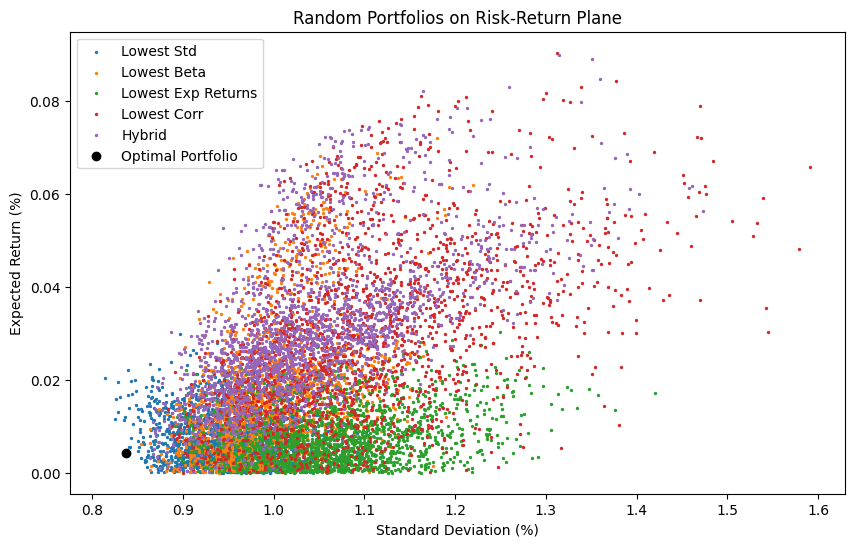

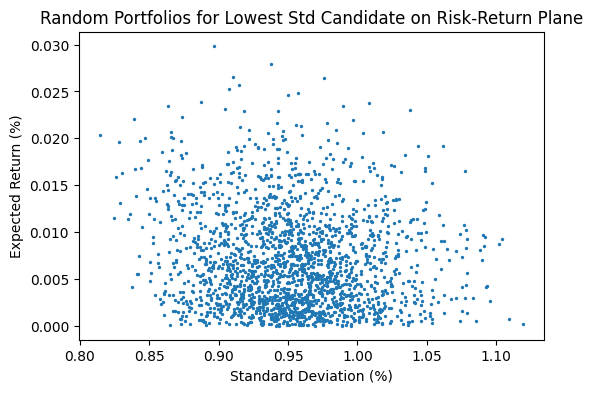

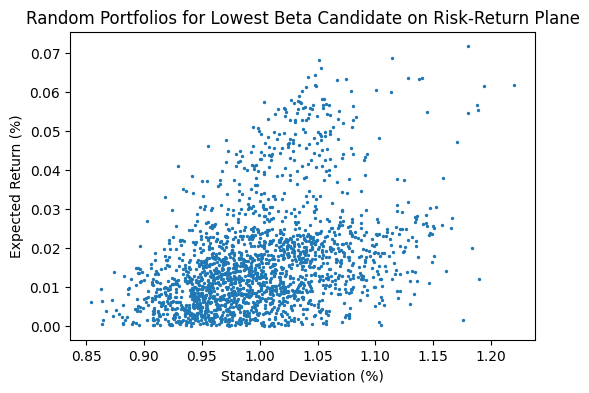

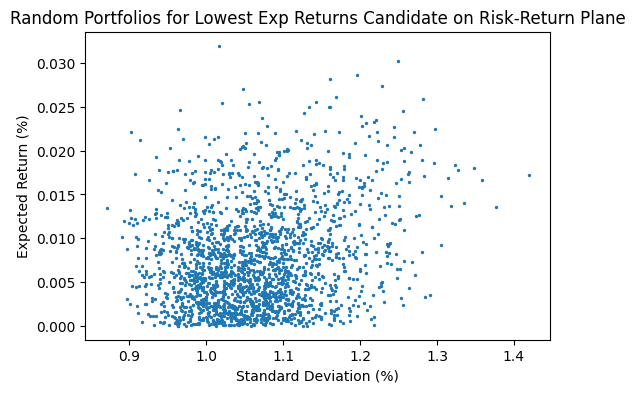

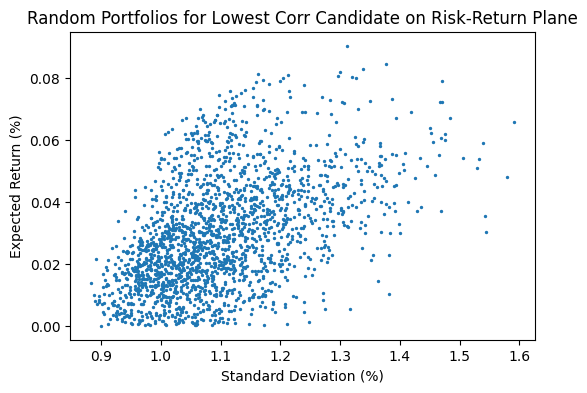

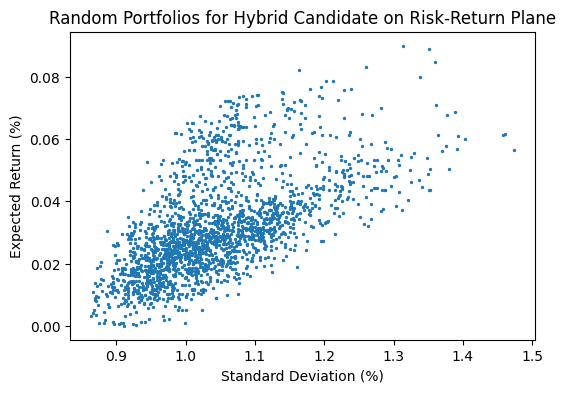

In [26]:
# Graph all of the random portfolios from all the different candidates
plt.figure(figsize=(10, 6))
for name, portfolio in portfolio_candidates.items():
    plt.scatter(port_std_devs[name].values(), port_exp_returns[name].values(), s=2, label=name)

plt.xlabel("Standard Deviation (%)")
plt.ylabel("Expected Return (%)")
plt.title("Random Portfolios on Risk-Return Plane")
# Change the colour of the optimal portfolio
plt.scatter(port_std_devs[best_candidate_name][best_i], port_exp_returns[best_candidate_name][best_i], color="black", label="Optimal Portfolio")
plt.legend()
plt.show()

# Individually graph the random portfolios for each portfolio candidate
for name, portfolio in portfolio_candidates.items():
    plt.figure(figsize=(6, 4))
    plt.scatter(port_std_devs[name].values(), port_exp_returns[name].values(), s=2)
    plt.xlabel("Standard Deviation (%)")
    plt.ylabel("Expected Return (%)")
    plt.title(f"Random Portfolios for {name} Candidate on Risk-Return Plane")

The first scatterplot above displays all the random portfolios we generated (where each point corresponds to (std, exp return) of the portfolio). Each of the portfolio candidates are shown in a different colour; we can see that the set of portfolios for each portfolio candidate share a similar trend and pattern. For example, all the green points (portfolios that were originally optimized for low expected returns) are low down on the y-axis (expected returns), but scattered across the x-axis (standard deviation). We noticed in our testing that the most optimal portfolio has often come from the low expected returns portfolio candidate. However, our method allows multiple portfolio strategies to be tested, and will automatically choose the portfolio that happens to be the most optimal.

In [29]:
prices = stock_data[best_tickers].iloc[len(stock_data)-1].tolist()

# Create final portfolio dataframe
Portfolio_Final = pd.DataFrame()
Portfolio_Final.index=range(1,len(best_tickers)+1)
Portfolio_Final["Ticker"] = best_tickers
Portfolio_Final["Price"] = prices
Portfolio_Final["Currency"] = ""
Portfolio_Final.loc[Portfolio_Final['Ticker'].isin(cad_tickers), "Currency"] = "CAD"
Portfolio_Final.loc[Portfolio_Final['Ticker'].isin(usd_tickers), "Currency"] = "USD"
Portfolio_Final["Weight"] = best_weights
Portfolio_Final["Value"] = (capital * Portfolio_Final["Weight"]) - trading_fee
Portfolio_Final["Shares"] = Portfolio_Final["Value"] / Portfolio_Final["Price"]

Portfolio_Final = Portfolio_Final[["Ticker", "Price", "Currency", "Shares", "Value", "Weight"]]
display(Portfolio_Final)

# Show that final value and weights make sense
# Note that in order to get to the original $750,000 CAD, we need to add back the trading fees since we needed to
# account for the trading fees before allocating capital to stocks
total_value = sum(Portfolio_Final["Value"]) + (trading_fee * num_stocks)
total_weights = sum(Portfolio_Final["Weight"])
print(f"The total value adds to ${total_value:.2f} CAD and the weights add to {total_weights:.2%}")

,Ticker,Price,Currency,Shares,Value,Weight
1,RY.TO,118.959999,CAD,1086.659001,129268.953815,0.172365
2,T.TO,24.059999,CAD,3999.526092,96228.595635,0.128311
3,TD.TO,83.349998,CAD,204.445178,17040.505276,0.022727
4,KO,80.211615,USD,212.444383,17040.507133,0.022727
5,PEP,231.952210,USD,577.647331,133986.574956,0.178655
6,CL,105.876042,USD,160.948077,17040.545427,0.022727
7,PG,207.314918,USD,82.196265,17040.511938,0.022727
8,BMY,68.146318,USD,307.468692,20952.859299,0.027944
9,MRK,139.510970,USD,122.144607,17040.512576,0.022727
10,PM,129.198626,USD,131.893865,17040.506154,0.022727


The total value adds to $750000.00 CAD and the weights add to 100.00%


In [28]:
Stocks_Final = Portfolio_Final[["Ticker", "Shares"]]
Stocks_Final.to_csv("Stocks_Group_15.csv")

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Ethan, Landon, Jessie